This code mainly functions as a throw it all together file where the simple search is evaluated based only on the features in the final data base. And then the results are visualised. 


In [54]:
import os
import pymeshlab as ml # this import has to be over here, even though it appears like its not being used
import pandas as pd
import numpy as np
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from fullNormalize import ShapeNormalizer
from dataResampleFinal import resample
from singleObjectCalcFinal import ObjectCalculations
from scipy.stats import wasserstein_distance
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import faiss

In [46]:
import os

import pymeshlab as ml # this import has to be over here, even though it appears like its not being used

import pandas as pd
import numpy as np

from tkinter import Tk
from tkinter.filedialog import askopenfilename

from fullNormalize import ShapeNormalizer
from dataResampleFinal import resample
from singleObjectCalcFinal import ObjectCalculations

from scipy.stats import wasserstein_distance

# 1. ask for INPUT .obj file
# 2. resample and normalize INPUT
# 3. extract INPUT features
# 4. create feature vector for INPUT

# 5. calculate similarity between INPUT and DATASET by normalization [0, &] or [0, 1]


class searchObject:
    def __init__(self, bins, n, search_object_features):
        self.bins = bins
        self.n = n

        self.single_val_features = ["surfaceAreaObj","compactnessObj","rectangularityObj","diameterObj","convexityObj","eccentricityObj"]
        self.hist_features = ["A3","D1","D2","D3","D4"]

        self.file_path = ""
        self.temp_file_path = ""
        self.features = {}

        self.distances = {}

        self.load(search_object_features)


    def load(self, search_object_features):
        # Hide the main tkinter window
        root = Tk()
        root.withdraw()
        
        if search_object_features == None:

            # Open file dialog to select a file
            file_path = askopenfilename(
                filetypes=[("OBJ files", "*.obj")],
                title="Select an OBJ file"
            )

            if not file_path:
                print("[Error] preprocessing: No file selected!")
                return

            # Process the selected file
            #print(f"[Started] preprocessing: {file_path}")

            self.file_path = file_path

            # prepare object for comparison task
            self.preprocess()
            self.normalizedfeatures()
        else:
            # fill in self.features with search_object_features
            self.features = {
                "surfaceAreaObj": search_object_features[0],
                "compactnessObj": search_object_features[1],
                "rectangularityObj": search_object_features[2],
                "diameterObj": search_object_features[3],
                "convexityObj": search_object_features[4],
                "eccentricityObj": search_object_features[5],
                "A3": search_object_features[6],
                "D1": search_object_features[7],
                "D2": search_object_features[8],
                "D3": search_object_features[9],
                "D4": search_object_features[10]
            }
            #self.features = self.normalizedfeatures()
            #print("[Info] features: search object features extracted for search task!")

            
        # compare object to dataset
        self.compare()

        # get a single distance score per object
        self.combineFeatureDistances()

    def preprocess(self):
        file_path_list = self.file_path.split("/")
        obj_name = file_path_list[-1]
        obj_class = file_path_list[-2]
        
        resample(obj_name, obj_class, aim=4000, deviation=0.9, searchTask=True)
        
        temp_file_path_in = os.path.join(os.getcwd(), "steps\\step4\\temp.obj")
        temp_file_path_out = os.path.join(os.getcwd(), "steps\\step4")

        self.temp_file_path = temp_file_path_in

        normalizer = ShapeNormalizer()
        normalizer.select_and_normalize_single_file(temp_file_path_out, temp_file_path_in) 


    def normalizedfeatures(self):

        # load values to standardize with
        df_features_means_stds = pd.read_csv("searchStandardizationData.csv")

        # standardize single-value features (hist features already done)
        for single_val_feature in self.single_val_features:
            mean = df_features_means_stds.at[0, single_val_feature]
            std = df_features_means_stds.at[1, single_val_feature]

            # update the value itself
            self.features[single_val_feature] = abs((self.features[single_val_feature] - mean) / std)
        print(self.features)
        return self.features



    def compare(self):
        df = pd.read_csv("dataBaseFinal.csv")

        # euclidean distance (hist features)
        # distance_features = {}
        # for hist_feature in self.hist_features:
        #     source = np.array(self.features[hist_feature])
        #     targets = df[hist_feature]

        #     # iterate every object from the dataset
        #     distance_feature = []
        #     for target in targets:
        #         target = np.array(eval(target))
                
        #         combined = source - target
        #         ss = np.dot(combined.T, combined)
                
        #         distance_feature.append(np.sqrt(ss))
            
        #     distance_features[hist_feature] = distance_feature

        # earth movers distance (hist features)
        distance_features = {}
        for hist_feature in self.hist_features:
            source = np.array(self.features[hist_feature])
            targets = df[hist_feature]

            # iterate every object from the dataset
            distance_feature = []
            for target in targets:
                target = np.array(eval(target))
                
                d = wasserstein_distance(source, target)
                
                distance_feature.append(np.sqrt(d))
            
            distance_features[hist_feature] = distance_feature


        # distance single-value features
        for single_val_feature in self.single_val_features:
            source = self.features[single_val_feature]
            targets = df[single_val_feature]

            # iterate every object from the dataset
            distance_feature = []
            for target in targets:
                distance_feature.append(abs(source - target))

            distance_features[single_val_feature] = distance_feature

        # standardize hist features so they can be compared properly
        standardized_distance_features = {"name": df["name"].to_list(),
                                          "class": df["class"].to_list()}
        for distance_feature_key, distance_feature_values in distance_features.items():
            if distance_feature_key in self.hist_features:
                mean = np.mean(distance_feature_values)
                std = np.std(distance_feature_values)

                # iterate every single value of a single feature
                standardized_distance_feature = []
                for distance_feature_value in distance_feature_values:
                    standardized_distance_feature.append((distance_feature_value - mean) / std)

                standardized_distance_features[distance_feature_key] = standardized_distance_feature
            # ignore single-value features since they have already been normalized
            else:
                standardized_distance_features[distance_feature_key] = distance_feature_values


        # save the data
        self.distances = standardized_distance_features

    def combineFeatureDistances(self):
        df_distances = pd.DataFrame(self.distances)

        # make all distance values positive
        df_distances = pd.concat([df_distances[["name", "class"]], df_distances.iloc[ :, 2:13].abs()], axis=1)
        
        # df_distances = df_distances.drop(["D1"], axis=1)

        # grab mean distance from all features of a single object (row mean)
        df_distances["closeness"] = df_distances.iloc[ :, 2:13].mean(axis=1) # 7 to skip hist features
        # print(df_distances)
        # update distances
        self.distances = df_distances[["name", "class", "closeness"]]
        self.distances = self.distances.sort_values(["closeness"], ascending=True)
        self.distances.to_csv("searchResult.csv", index=False)

        #print("[Finished] distances: feature distance computations done")


In [ ]:
df = pd.read_csv("dataBaseFinal.csv")
object_class_top10_list = []
results = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
}
iteration = 0
for object in df.iterrows():
    # create the features for the search query
    object_features = []
    #print(object[1]["name"]) # name of class
    #print(object[1]["surfaceAreaObj"])
    object_features.append(object[1]["surfaceAreaObj"])
    object_features.append(object[1]["compactnessObj"])
    object_features.append(object[1]["rectangularityObj"])
    object_features.append(object[1]["diameterObj"])
    object_features.append(object[1]["convexityObj"])
    object_features.append(object[1]["eccentricityObj"])
    object_features.append(eval(object[1]["A3"]))
    object_features.append(eval(object[1]["D1"]))
    object_features.append(eval(object[1]["D2"]))
    object_features.append(eval(object[1]["D3"]))
    object_features.append(eval(object[1]["D4"]))
    object_class = object[1]["class"]
    
    # fetch results
    result = searchObject(100000, 93, object_features)

    top10_classes = result.distances.head(5)["class"].tolist()
    class_overlap = top10_classes.count(object_class)
    object_class_top10_list.append((object_class, top10_classes))
    results[class_overlap] += 1

    iteration += 1
    print(f"[Info]: {iteration} / 2483 items done ({round((iteration / 2483) * 100, 2)}%) --> {results}")

print("\n--------------------------------------------------------------------------------------------")
print(results)



[Info]: 1 / 2483 items done (0.04%) --> {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0}
[Info]: 2 / 2483 items done (0.08%) --> {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0}
[Info]: 3 / 2483 items done (0.12%) --> {0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0}
[Info]: 4 / 2483 items done (0.16%) --> {0: 2, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0}
[Info]: 5 / 2483 items done (0.2%) --> {0: 2, 1: 2, 2: 0, 3: 1, 4: 0, 5: 0}
[Info]: 6 / 2483 items done (0.24%) --> {0: 3, 1: 2, 2: 0, 3: 1, 4: 0, 5: 0}
[Info]: 7 / 2483 items done (0.28%) --> {0: 3, 1: 3, 2: 0, 3: 1, 4: 0, 5: 0}
[Info]: 8 / 2483 items done (0.32%) --> {0: 3, 1: 3, 2: 1, 3: 1, 4: 0, 5: 0}
[Info]: 9 / 2483 items done (0.36%) --> {0: 4, 1: 3, 2: 1, 3: 1, 4: 0, 5: 0}
[Info]: 10 / 2483 items done (0.4%) --> {0: 4, 1: 4, 2: 1, 3: 1, 4: 0, 5: 0}
[Info]: 11 / 2483 items done (0.44%) --> {0: 5, 1: 4, 2: 1, 3: 1, 4: 0, 5: 0}
[Info]: 12 / 2483 items done (0.48%) --> {0: 6, 1: 4, 2: 1, 3: 1, 4: 0, 5: 0}
[Info]: 13 / 2483 items done (0.52%) --> {0: 7, 1: 4, 2: 1, 3: 1, 4: 0, 5: 

In [51]:
#[Info]: 2481 / 2483 items done (99.92%) --> {0: 2149, 1: 267, 2: 54, 3: 9, 4: 1, 5: 1}
everything = object_class_top10_list

In [88]:
print(everything)

[('AircraftBuoyant', ['AircraftBuoyant', 'HumanHead', 'Cellphone', 'Rocket', 'HumanHead']), ('AircraftBuoyant', ['AircraftBuoyant', 'Rocket', 'AircraftBuoyant', 'AircraftBuoyant', 'Jet']), ('AircraftBuoyant', ['Jet', 'Jet', 'DeskLamp', 'Bird', 'Bird']), ('AircraftBuoyant', ['City', 'PlantWildNonTree', 'Insect', 'PlantIndoors', 'TruckNonContainer']), ('AircraftBuoyant', ['Biplane', 'Bird', 'Door', 'AircraftBuoyant', 'TruckNonContainer']), ('AircraftBuoyant', ['HumanHead', 'HumanHead', 'HumanHead', 'HumanHead', 'HumanHead']), ('AircraftBuoyant', ['Cellphone', 'HumanHead', 'Starship', 'AircraftBuoyant', 'Rocket']), ('AircraftBuoyant', ['AircraftBuoyant', 'HumanHead', 'HumanHead', 'AircraftBuoyant', 'Bird']), ('AircraftBuoyant', ['PlantIndoors', 'Truck', 'Tree', 'Ship', 'Jet']), ('AircraftBuoyant', ['Jet', 'AircraftBuoyant', 'Jet', 'House', 'Jet']), ('AircraftBuoyant', ['Apartment', 'Bottle', 'Cellphone', 'Hand', 'Hand']), ('AircraftBuoyant', ['Jet', 'Starship', 'Car', 'Jet', 'Biplane']), 

In [53]:
# Assuming results_df is already available from the previous code

def count_top_10_neighbors(tuples_list):
    # Initialize an empty dictionary to store the counts
    class_counts = {}

    # Iterate over each tuple in the list
    for object_class, top_5_neighbors in tuples_list:
        # Initialize a dictionary to store counts for the current object class
        if object_class not in class_counts:
            class_counts[object_class] = {}

        neighbor_counts = class_counts[object_class]

        # Count the occurrences of each neighbor class
        for neighbor_class in top_5_neighbors:
            if neighbor_class in neighbor_counts:
                neighbor_counts[neighbor_class] += 1
            else:
                neighbor_counts[neighbor_class] = 1

    # Convert the dictionary to a DataFrame for better readability
    counts_df = pd.DataFrame(class_counts).fillna(0).astype(int)

    return counts_df
# Example usage:
counts_df = count_top_10_neighbors(everything)
print(counts_df)

                 AircraftBuoyant  Apartment  AquaticAnimal  Bed  Bicycle  \
AircraftBuoyant               10          0              1    0        0   
HumanHead                     12          0              3    1        0   
Cellphone                      4          9              0    0        0   
Rocket                         3          1              2    0        0   
Jet                           12          1              5    6       14   
...                          ...        ...            ...  ...      ...   
SubmachineGun                  0          0              0    1        0   
AquaticAnimal                  0          0              0    1        0   
Bicycle                        0          0              0    0        0   
Hat                            0          0              0    0        0   
PianoBoard                     0          0              0    0        0   

                 Biplane  Bird  Bookset  Bottle  BuildingNonResidential  ...  \
Aircraf

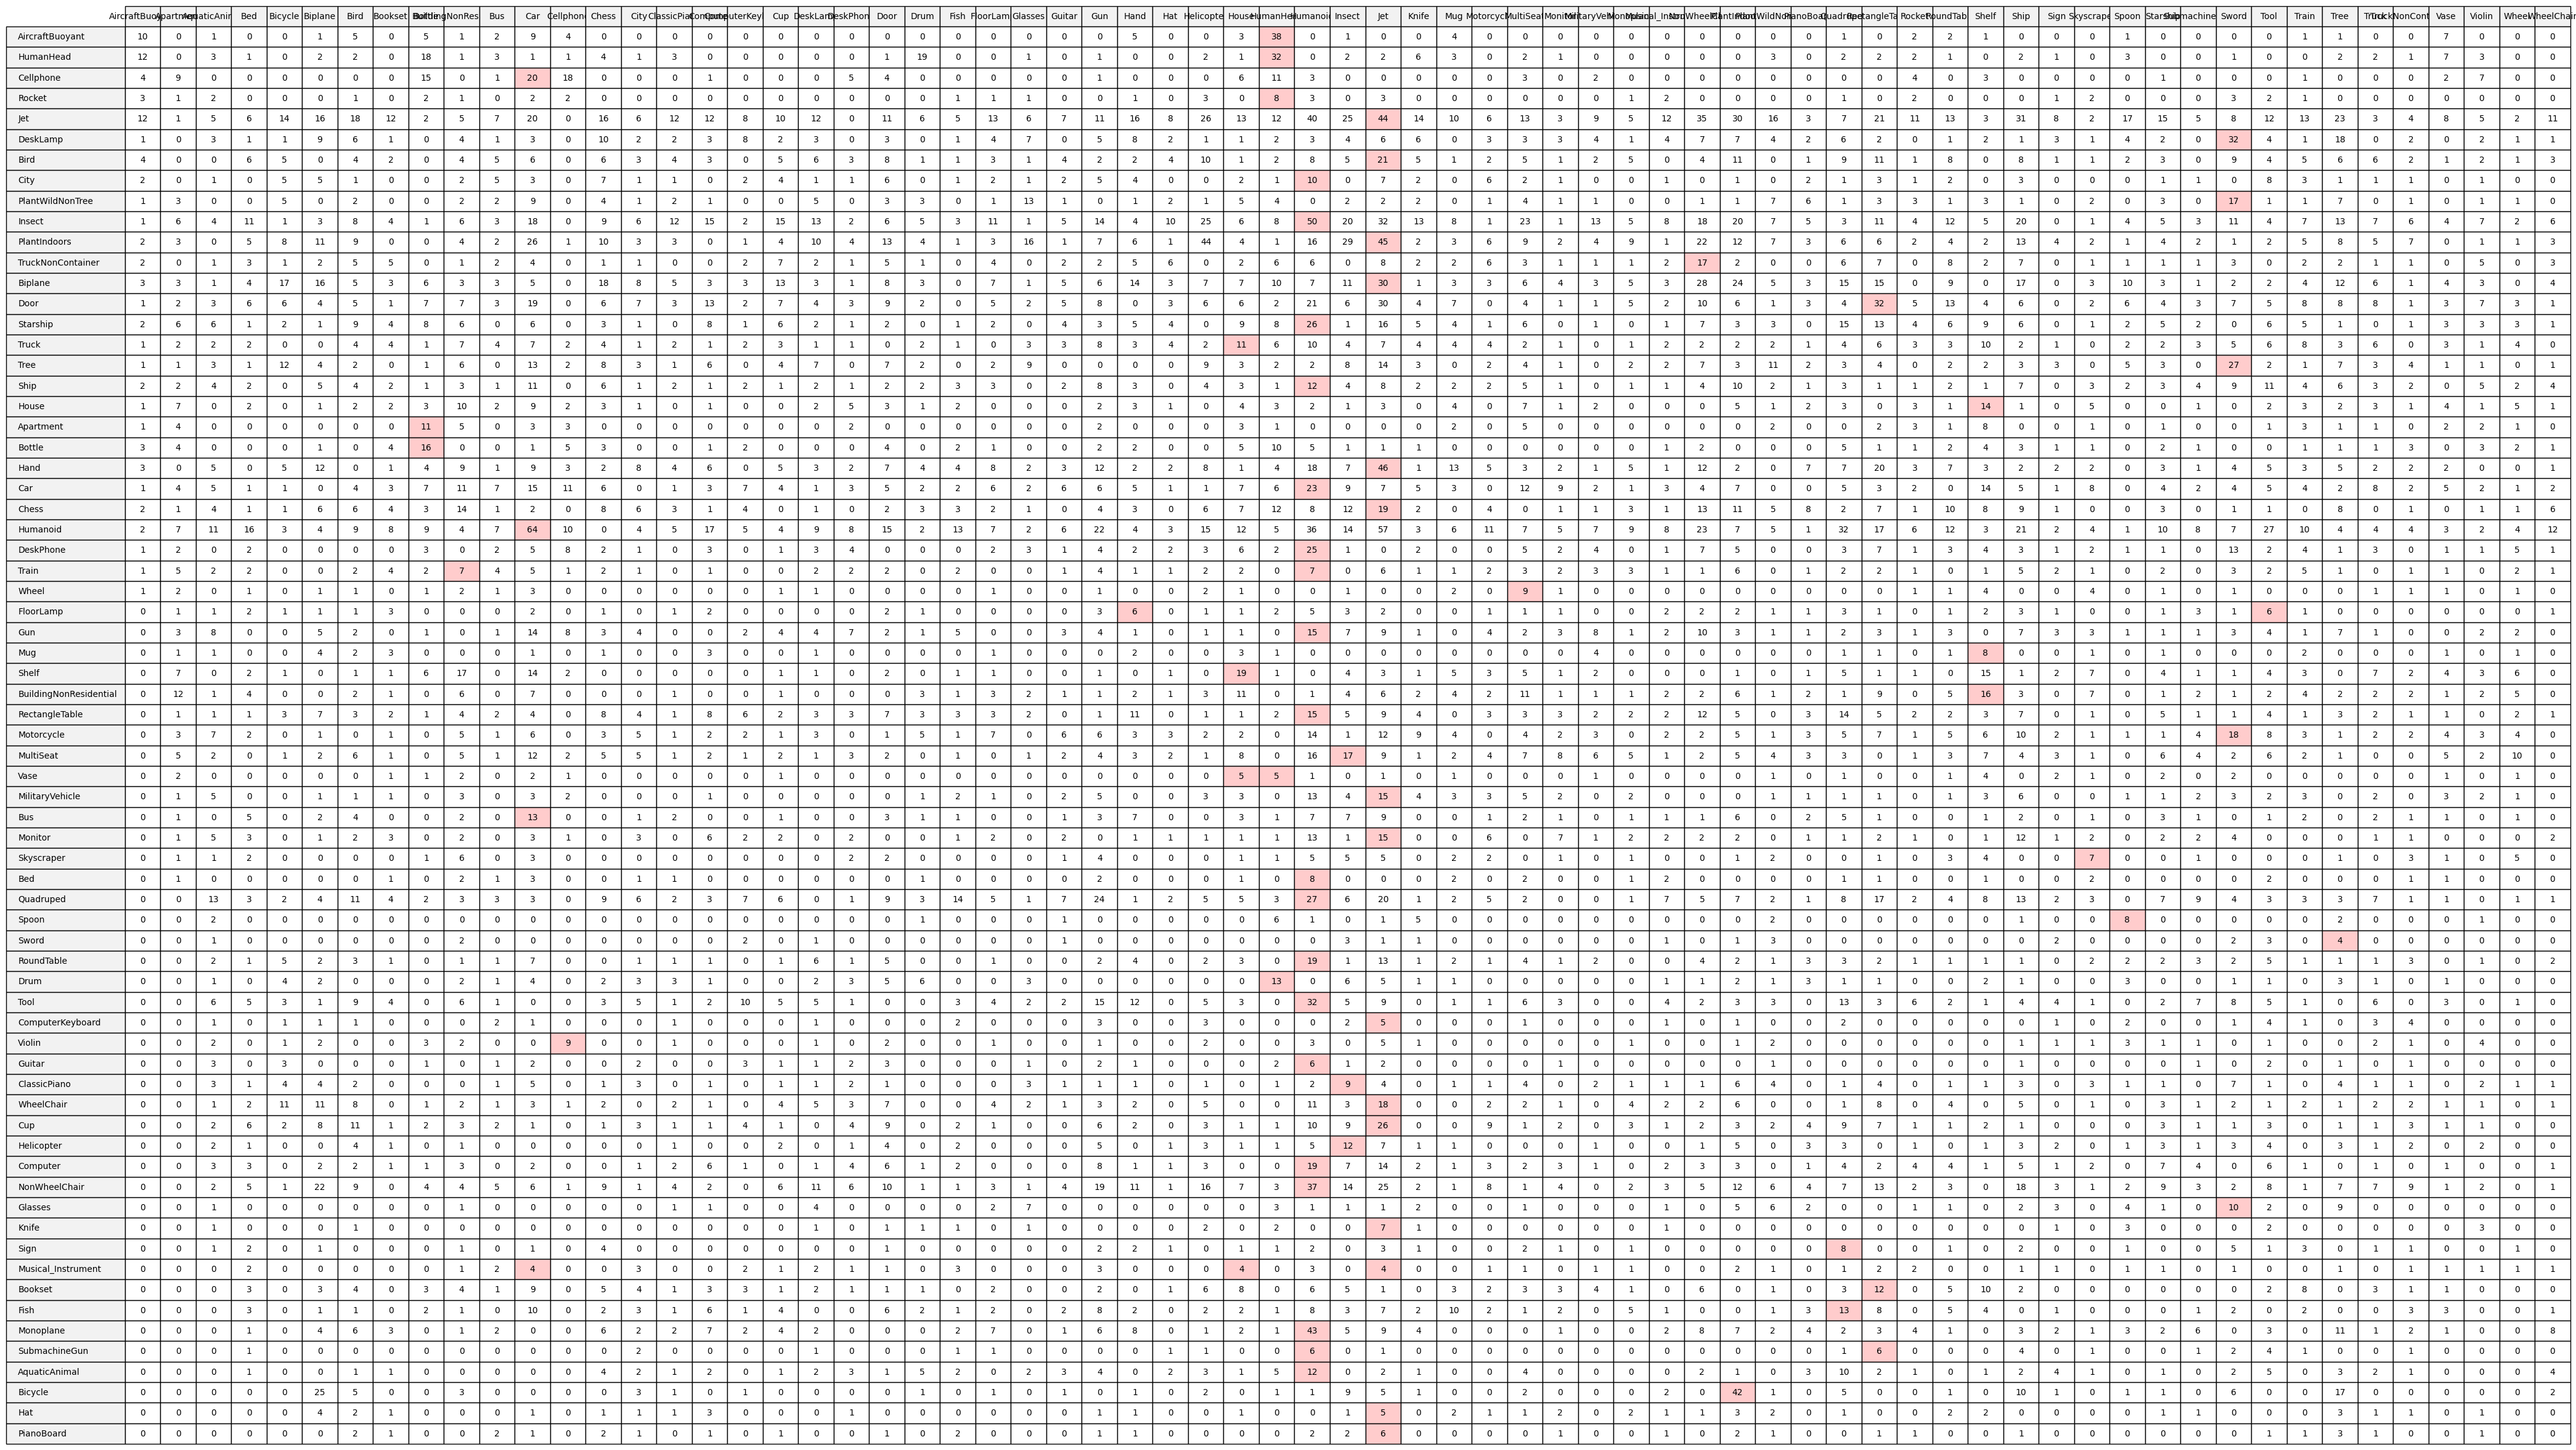

In [55]:
# Assuming counts_df is already available from the previous code

def visualize_counts_df(counts_df):
    fig, ax = plt.subplots()  # Set the figure size

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=counts_df.values,
                     colLabels=counts_df.columns,
                     rowLabels=counts_df.index,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*counts_df.shape[1],
                     rowColours=['#f2f2f2']*counts_df.shape[0])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(8, 2)  # Adjust the scale of the table
# Highlight the highest number in each row
    for i, row in enumerate(counts_df.values):
        max_val = np.max(row)
        for j, cell in enumerate(row):
            if cell == max_val:
                table[(i+1, j)].set_facecolor('#ffcccc')  # Highlight color

    plt.show()

# Example usage:
visualize_counts_df(counts_df)

               Unique Class                   First Most          Second Most  \
0      AircraftBuoyant (80)               HumanHead (12)             Jet (12)   
1           Apartment (115)  BuildingNonResidential (12)        Cellphone (9)   
2       AquaticAnimal (145)               Quadruped (13)        Humanoid (11)   
3                 Bed (135)                Humanoid (16)          Insect (11)   
4             Bicycle (130)                 Biplane (17)             Jet (14)   
..                      ...                          ...                  ...   
64  TruckNonContainer (100)            NonWheelChair (9)     PlantIndoors (7)   
65               Vase (100)                      Jet (8)  AircraftBuoyant (7)   
66             Violin (100)                Cellphone (7)           Insect (7)   
67               Wheel (85)               MultiSeat (10)            Shelf (6)   
68          WheelChair (90)                Humanoid (12)             Jet (11)   

              Third Most   

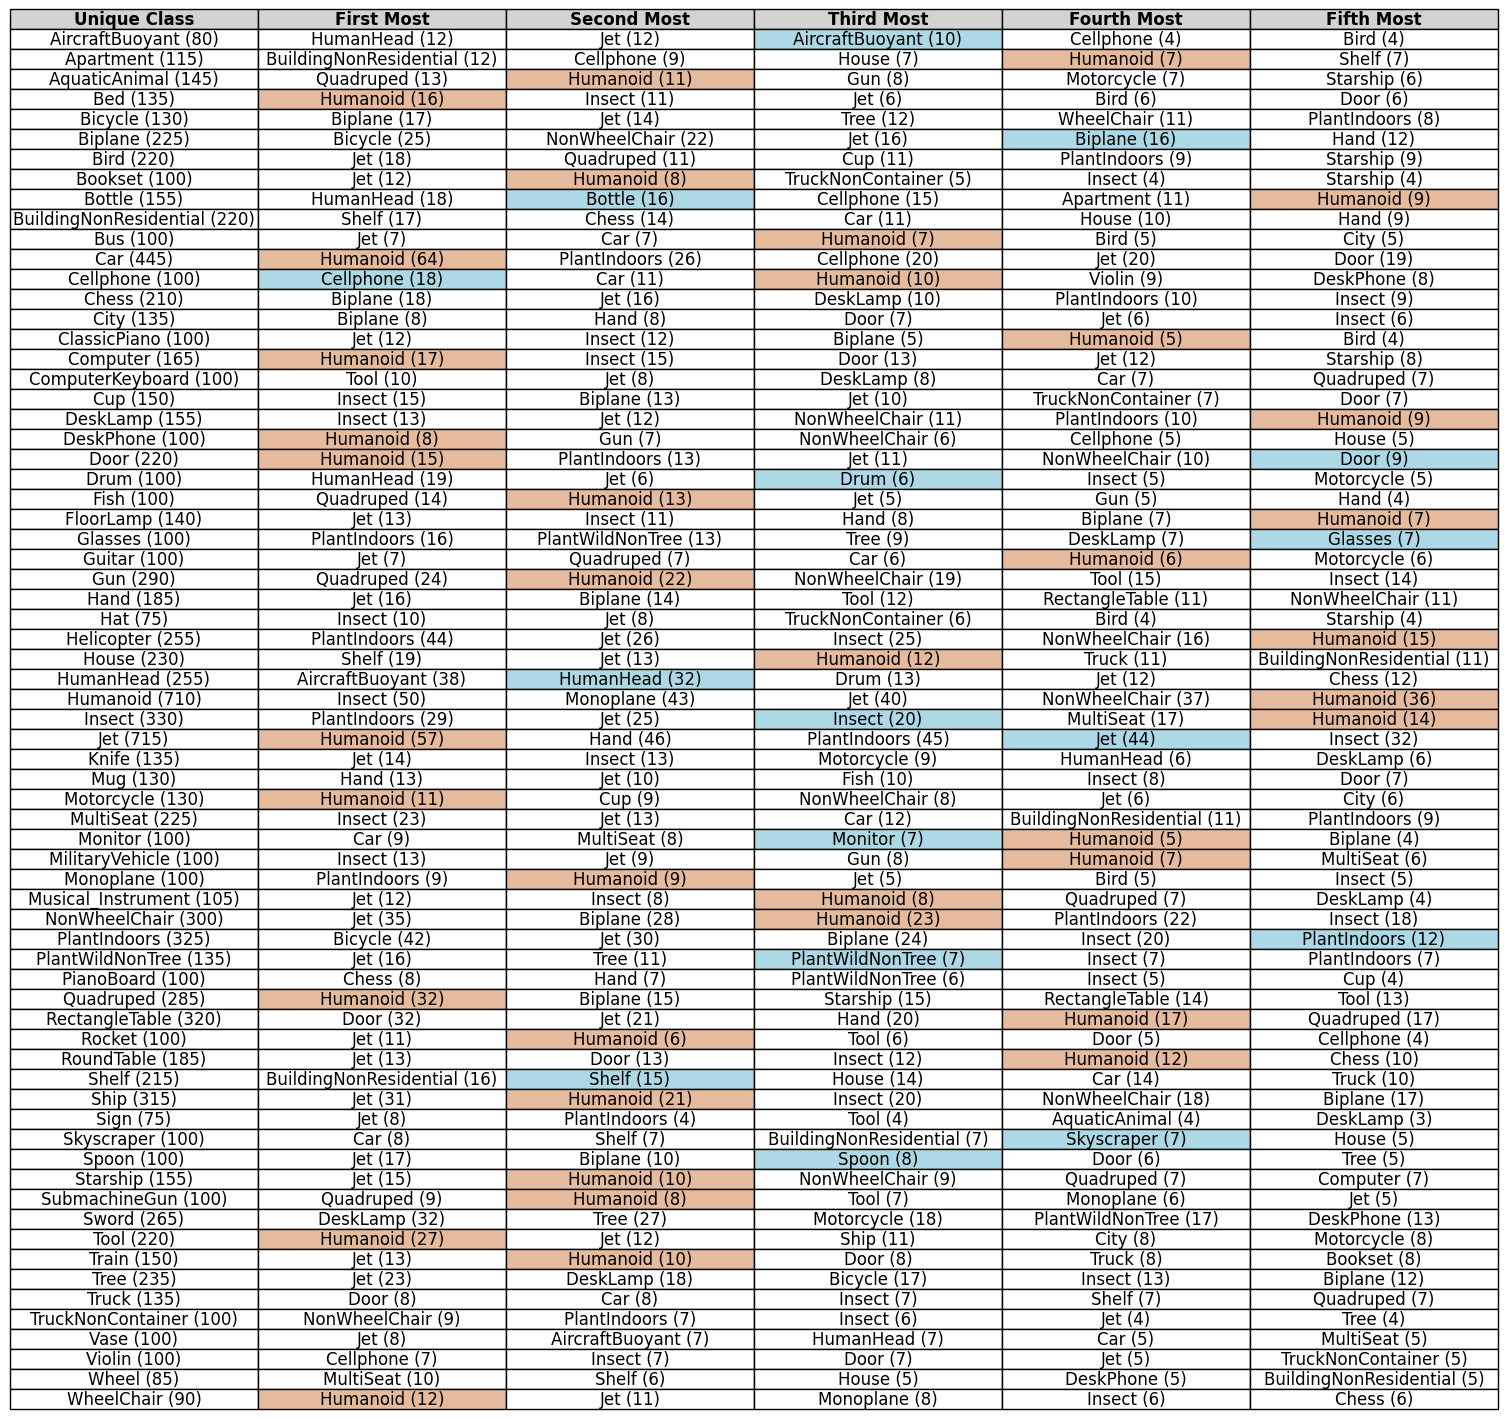

In [59]:
import pandas as pd

# Assuming counts_df is already available from the previous code

def get_top_5_classes_with_columns(counts_df):
    top_5_list = []

    # Iterate over each unique class in the counts_df
    for unique_class in counts_df.columns:
        # Get the counts for the current unique class
        class_counts = counts_df[unique_class]

        # Get the top 5 mentioned classes
        top_5_classes = class_counts.nlargest(5)

        # Create a dictionary to store the top 5 classes with their ranks
        top_5_dict = {
            'Unique Class': f"{ unique_class} ({int(class_counts.sum())})",
            'First Most': f"{top_5_classes.index[0]} ({top_5_classes.iloc[0]})" if len(top_5_classes) > 0 else None,
            'Second Most': f"{top_5_classes.index[1]} ({top_5_classes.iloc[1]})" if len(top_5_classes) > 1 else None,
            'Third Most': f"{top_5_classes.index[2]} ({top_5_classes.iloc[2]})" if len(top_5_classes) > 2 else None,
            'Fourth Most': f"{top_5_classes.index[3]} ({top_5_classes.iloc[3]})" if len(top_5_classes) > 3 else None,
            'Fifth Most': f"{top_5_classes.index[4]} ({top_5_classes.iloc[4]})" if len(top_5_classes) > 4 else None
        }

        # Append the dictionary to the list
        top_5_list.append(top_5_dict)

    # Convert the list to a DataFrame for better readability
    top_5_df = pd.DataFrame(top_5_list)

    return top_5_df

# Example usage:
# Assuming counts_df is already defined
top_5_df = get_top_5_classes_with_columns(counts_df)
print(top_5_df)


import matplotlib.pyplot as plt

# Function to visualize the top_5_df as a nice table with bold headers, light grey background, and light blue color for matching classes
def visualize_top_5_df_with_styling_and_highlight(top_5_df):
    fig, ax = plt.subplots()  # Set the figure size

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=top_5_df.values,
                     colLabels=top_5_df.columns,
                     cellLoc='center',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(3, 1.2)  # Adjust the scale of the table

    # Style the header
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_text_props(weight='bold')  # Make header text bold
            cell.set_facecolor('#d3d3d3')  # Light grey background

    # Highlight the class that is the same as the unique class with light blue color
    for i, row in enumerate(top_5_df.values):
        unique_class = row[0].split(' (')[0]  # Extract the unique class name
        for j, cell in enumerate(row[1:], start=1):
            if unique_class in cell:
                table[(i+1, j)].set_facecolor('#add8e6') # Light blue color
            if "Humanoid" in cell:
                table[(i+1, j)].set_facecolor('#e6bb9d')  

    plt.show()

# Example usage:
visualize_top_5_df_with_styling_and_highlight(top_5_df)

In [93]:
dataLeft = [('AircraftBuoyant', [1, 0, 0, 0, 0]), ('AircraftBuoyant', [1, 0, 1, 1, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 1, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 1, 0]), ('AircraftBuoyant', [1, 0, 0, 1, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 1, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [1, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 1, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 1, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [1, 0, 0, 0, 1]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('AquaticAnimal', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bed', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Bicycle', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 1]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 1, 0, 0]), ('Biplane', [0, 0, 1, 0, 0]), ('Biplane', [0, 0, 0, 0, 1]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 1, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 1, 0, 0, 1]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 1]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 1, 1, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 1, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [1, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 1]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 1, 0, 0, 0]), ('Biplane', [1, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 1, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Biplane', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 1]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 1, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 1, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 1, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bird', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bookset', [0, 0, 0, 0, 0]), ('Bottle', [1, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [1, 1, 0, 1, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [1, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [1, 0, 0, 1, 1]), ('Bottle', [1, 0, 0, 1, 0]), ('Bottle', [0, 1, 0, 0, 0]), ('Bottle', [1, 0, 0, 0, 1]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [1, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 1]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 1, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('Bottle', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [1, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 1, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [1, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 1, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 1]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 1, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('BuildingNonResidential', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Bus', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 1]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 1, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [1, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [1, 0, 1, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 1, 0, 0, 0]), ('Car', [1, 0, 1, 1, 0]), ('Car', [1, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [1, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 1]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 0, 0]), ('Car', [0, 0, 0, 1, 0]), ('Car', [1, 1, 0, 0, 0]), ('Cellphone', [0, 0, 0, 0, 0]), ('Cellphone', [1, 0, 0, 0, 0]), ('Cellphone', [0, 1, 0, 0, 1]), ('Cellphone', [0, 0, 0, 0, 0]), ('Cellphone', [1, 0, 1, 0, 1]), ('Cellphone', [0, 0, 0, 0, 0]), ('Cellphone', [0, 0, 0, 0, 0]), ('Cellphone', [1, 1, 0, 0, 0]), ('Cellphone', [0, 0, 0, 0, 0]), ('Cellphone', [0, 0, 0, 0, 0]), ('Cellphone', [0, 0, 0, 1, 0]), ('Cellphone', [1, 0, 0, 0, 0]), ('Cellphone', [0, 0, 0, 0, 0]), ('Cellphone', [1, 0, 0, 0, 1]), ('Cellphone', [0, 0, 0, 0, 0]), ('Cellphone', [0, 0, 0, 0, 1]), ('Cellphone', [0, 1, 1, 0, 0]), ('Cellphone', [0, 0, 0, 1, 1]), ('Cellphone', [0, 0, 0, 0, 0]), ('Cellphone', [0, 1, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [1, 1, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 1]), ('Chess', [0, 0, 0, 0, 1]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 1, 1, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 1, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 1]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('Chess', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 1]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('City', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('ClassicPiano', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 1, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [1, 0, 1, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 1, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [1, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [1, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('Computer', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('ComputerKeyboard', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 1, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('Cup', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [1, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskLamp', [1, 0, 1, 0, 0]), ('DeskLamp', [0, 0, 0, 0, 0]), ('DeskPhone', [1, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [1, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 1, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 1]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('DeskPhone', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 1, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [1, 0, 0, 0, 1]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 1, 0, 1, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [1, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 1, 0, 0]), ('Door', [0, 0, 0, 0, 1]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 1]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Door', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 1, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 1, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 1, 1, 0]), ('Drum', [1, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 1, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Drum', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 1, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('Fish', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('FloorLamp', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 1, 1, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [1, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 1, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 1, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Glasses', [0, 0, 0, 1, 0]), ('Glasses', [0, 1, 0, 0, 0]), ('Glasses', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Guitar', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 1]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 1, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 1, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 1, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Gun', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 1, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 1, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hand', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Hat', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 1, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [0, 0, 0, 0, 0]), ('Helicopter', [1, 0, 1, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 1, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 1, 0, 0, 0]), ('House', [1, 0, 0, 1, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('House', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 1, 0, 1]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [1, 0, 0, 0, 0]), ('HumanHead', [1, 0, 1, 1, 0]), ('HumanHead', [0, 1, 0, 0, 1]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [1, 0, 1, 0, 0]), ('HumanHead', [0, 0, 1, 0, 0]), ('HumanHead', [1, 1, 0, 0, 0]), ('HumanHead', [0, 1, 1, 0, 0]), ('HumanHead', [1, 1, 0, 1, 1]), ('HumanHead', [0, 0, 1, 1, 0]), ('HumanHead', [0, 1, 0, 1, 0]), ('HumanHead', [0, 0, 0, 0, 1]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 1, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 1, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 1, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 1, 0, 1]), ('HumanHead', [0, 0, 1, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 1]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 1, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('HumanHead', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 1, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 1, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 1, 0, 0, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 1, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 1, 0, 0, 0]), ('Humanoid', [0, 0, 0, 1, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 1]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 1]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 1, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 1, 0, 1, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 1, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [1, 1, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 1, 0, 0, 0]), ('Humanoid', [0, 0, 0, 1, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 1]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 1, 0, 0]), ('Humanoid', [1, 1, 0, 0, 0]), ('Humanoid', [0, 1, 1, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [1, 1, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [1, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 1, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 1]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Humanoid', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [1, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 1, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 1, 0, 1]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 1, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 1, 0, 0, 0]), ('Insect', [0, 0, 1, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 1, 0, 0]), ('Insect', [0, 0, 0, 1, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 1, 0, 0, 0]), ('Insect', [0, 1, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 1, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [1, 0, 0, 0, 0]), ('Insect', [1, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 1, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 1, 0, 1, 0]), ('Insect', [0, 0, 0, 0, 1]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 1]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 1, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Insect', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 1, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 1, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 1, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 1, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 1, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 1]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 1, 0, 0, 1]), ('Jet', [0, 1, 1, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 1, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 1, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 1]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 1, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 1]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 1, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 1, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 1]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 1]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 1]), ('Mug', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 1, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('Jet', [0, 1, 0, 0, 1]), ('Knife', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 1, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 1, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Monitor', [1, 1, 0, 1, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Jet', [0, 1, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 1, 1, 1]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 1]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 1, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 1, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 1, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('MultiSeat', [1, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Knife', [0, 1, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('MultiSeat', [1, 0, 1, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Monitor', [1, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 1, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [1, 1, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Jet', [1, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Monitor', [1, 0, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 1, 0, 0]), ('Knife', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MilitaryVehicle', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Monitor', [0, 0, 0, 1, 0]), ('Mug', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 0, 0, 0]), ('Musical_Instrument', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('MultiSeat', [0, 0, 1, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Motorcycle', [0, 0, 0, 0, 0]), ('Monitor', [0, 1, 0, 0, 0]), ('Mug', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Jet', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Monoplane', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 1, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 1, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 1, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 1, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 1, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 1, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 1, 1]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [1, 0, 0, 0, 1]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 1, 0, 1, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 1, 0, 0, 0]), ('Quadruped', [0, 1, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 1, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 1, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 1, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 1, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 1]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 1, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 1]), ('Rocket', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 1, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 1, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 1, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [1, 1, 1, 1, 1]), ('Quadruped', [0, 0, 1, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 1, 0, 0]), ('Quadruped', [0, 0, 0, 0, 1]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 1]), ('RectangleTable', [1, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 1]), ('Quadruped', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('Rocket', [1, 0, 1, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('Quadruped', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('NonWheelChair', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 1]), ('Shelf', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('PlantIndoors', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 1, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('PianoBoard', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 1, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Ship', [1, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 1]), ('Starship', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Spoon', [1, 1, 1, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('RectangleTable', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 1, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 1, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 1]), ('Skyscraper', [0, 0, 0, 1, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('PlantWildNonTree', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 1]), ('Sign', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 1, 0]), ('Shelf', [0, 0, 1, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Rocket', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 1, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Ship', [0, 1, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 1, 1, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 1, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 1, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Spoon', [0, 1, 1, 0, 0]), ('Starship', [1, 0, 0, 0, 0]), ('Shelf', [0, 0, 1, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Shelf', [1, 0, 0, 1, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 1, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 1, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Ship', [1, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 1, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 1]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 1, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('SubmachineGun', [1, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 1, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [1, 1, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('Shelf', [1, 0, 0, 1, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 1, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 1, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 1, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 1]), ('RoundTable', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 1, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('RoundTable', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 1]), ('Spoon', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('Tool', [1, 1, 0, 0, 0]), ('Spoon', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Shelf', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Sign', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Skyscraper', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('SubmachineGun', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Ship', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Ship', [0, 1, 0, 0, 0]), ('Starship', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 1, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Starship', [1, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 1, 0, 0]), ('Sword', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tree', [1, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 1, 0, 0]), ('Train', [0, 0, 0, 1, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Tree', [0, 1, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tree', [1, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Violin', [1, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 1]), ('Truck', [1, 0, 1, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 1, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 1]), ('Tool', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 1, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 1, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Train', [0, 0, 1, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Train', [1, 0, 0, 0, 0]), ('Vase', [0, 0, 1, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Truck', [1, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 1, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Tool', [0, 1, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Train', [0, 1, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Violin', [1, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Tree', [0, 1, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Tool', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Train', [0, 0, 0, 1, 0]), ('Truck', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 1, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 1, 0]), ('Truck', [0, 0, 0, 0, 0]), ('TruckNonContainer', [0, 0, 0, 0, 0]), ('Tree', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Violin', [0, 0, 0, 0, 0]), ('Vase', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('Wheel', [0, 0, 0, 0, 0]), ('Truck', [0, 1, 0, 0, 0]), ('Truck', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 1, 0]), ('Truck', [0, 1, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0]), ('WheelChair', [0, 0, 0, 0, 0])]


In [95]:
def transform_classnames(data):
    result = []
    for classname, classlist in data:
        transformed_list = [1 if item == classname else 0 for item in classlist]
        result.append((classname, transformed_list))
    return result

def flatten_and_sum(data):
    # Initialize a dictionary to store the sums and counts for each unique classname
    classname_sums = {}
    classname_counts = {}
    
    for classname, classlist in data:
        if classname not in classname_sums:
            classname_sums[classname] = [0] * len(classlist)
            classname_counts[classname] = 0
        
        # Sum the values for each position
        classname_sums[classname] = [sum(x) for x in zip(classname_sums[classname], classlist)]
        # Increment the count for the current classname
        classname_counts[classname] += 1
    
    # Convert the dictionary back to the desired format
    result = [(classname, sum(sums), classname_counts[classname]) for classname, sums in classname_sums.items()]
    return result

# Example usage
everything = dataLeft

transformed_data = transform_classnames(everything)
print("Transformed Data:", transformed_data)

flattened_data = flatten_and_sum(everything)
print("Flattened Data:", flattened_data)

Transformed Data: [('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('AircraftBuoyant', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 0, 0, 0]), ('Apartment', [0, 0, 

In [110]:
def calculate_precision_recall(data):
    class_metrics = []
    total_correct = 0
    total_attempts = 0
    total_relevant = 0
    
    for classname, correct, count in data:
        total_relevant_class = count * count
        total_attempts_class = count * 5  # Each class has 'count' objects, each with 5 attempts
        precision = correct / total_attempts_class if total_attempts_class > 0 else 0
        recall = correct / total_relevant_class if total_relevant_class > 0 else 0
        class_metrics.append({
            'class': (classname, count * 5),
            'avg_precision': precision,
            'recall': recall
        })
        
        total_correct += correct
        total_attempts += total_attempts_class
        total_relevant += total_relevant_class
    
    overall_precision = total_correct / total_attempts if total_attempts > 0 else 0
    overall_recall = total_correct / total_relevant if total_relevant > 0 else 0
    
    return class_metrics, overall_precision, overall_recall

# Example usage
data = flattened_data

class_metrics, overall_precision, overall_recall = calculate_precision_recall(data)

# Store results in a list
results = class_metrics

# Example of accessing the results
for result in results:
    print(f"Class {result['class']}: Precision = {result['avg_precision']:.5f}, Recall = {result['recall']:.5f}")

print(f"\nOverall Precision: {overall_precision:.5f}")
print(f"Overall Recall: {overall_recall:.5f}")


Class ('AircraftBuoyant', 80): Precision = 0.12500, Recall = 0.03906
Class ('Apartment', 115): Precision = 0.03478, Recall = 0.00756
Class ('AquaticAnimal', 145): Precision = 0.00000, Recall = 0.00000
Class ('Bed', 135): Precision = 0.00000, Recall = 0.00000
Class ('Bicycle', 130): Precision = 0.00000, Recall = 0.00000
Class ('Biplane', 225): Precision = 0.07111, Recall = 0.00790
Class ('Bird', 220): Precision = 0.01818, Recall = 0.00207
Class ('Bookset', 100): Precision = 0.00000, Recall = 0.00000
Class ('Bottle', 155): Precision = 0.10323, Recall = 0.01665
Class ('BuildingNonResidential', 220): Precision = 0.02727, Recall = 0.00310
Class ('Bus', 100): Precision = 0.00000, Recall = 0.00000
Class ('Car', 445): Precision = 0.03371, Recall = 0.00189
Class ('Cellphone', 100): Precision = 0.18000, Recall = 0.04500
Class ('Chess', 210): Precision = 0.03810, Recall = 0.00454
Class ('City', 135): Precision = 0.00741, Recall = 0.00137
Class ('ClassicPiano', 100): Precision = 0.00000, Recall = 

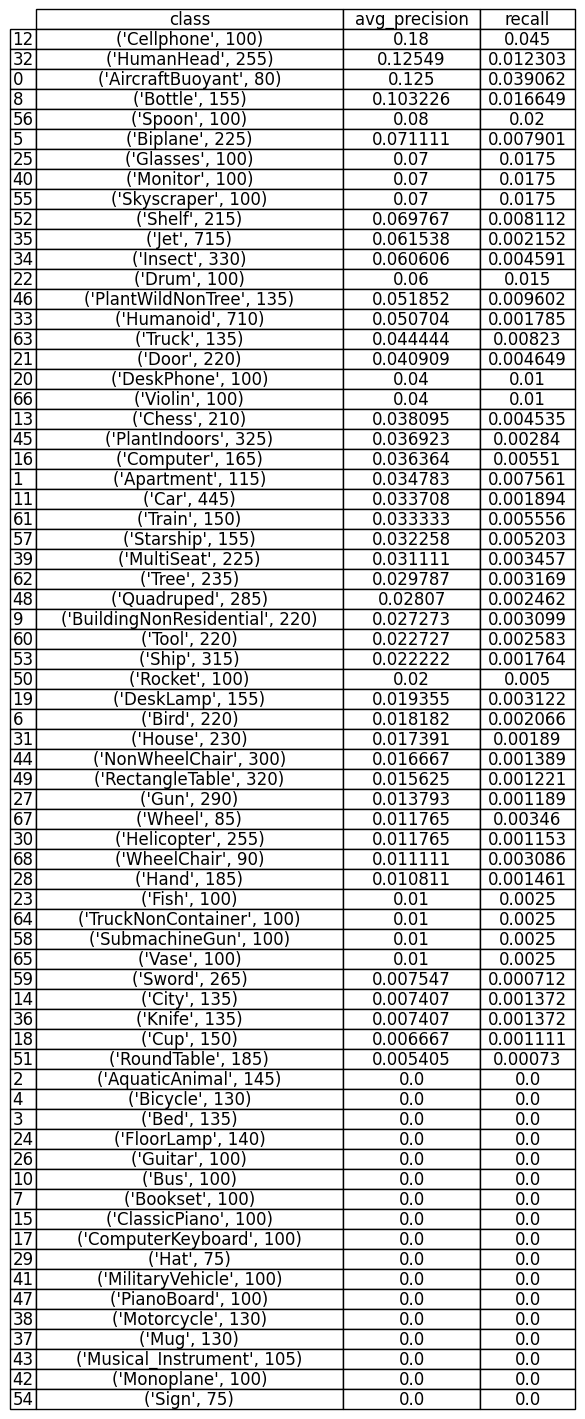

: 

In [ ]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(results)

# Format the float values to 5 decimal places
df = df.round(6)
df = df.sort_values(by='avg_precision', ascending=False)
# Plot the table using matplotlib
fig, ax = plt.subplots()  # Set size frame
ax.axis('tight')
ax.axis('off')
table = pd.plotting.table(ax, df, loc='center', cellLoc='center', colWidths=[0.2]*len(df.columns))

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2.2, 1.2)

# Remove the index column
table.auto_set_column_width([0, 1, 2])
for key, cell in table.get_celld().items():
    if key[1] == -1:
        cell.visible = False

plt.show()

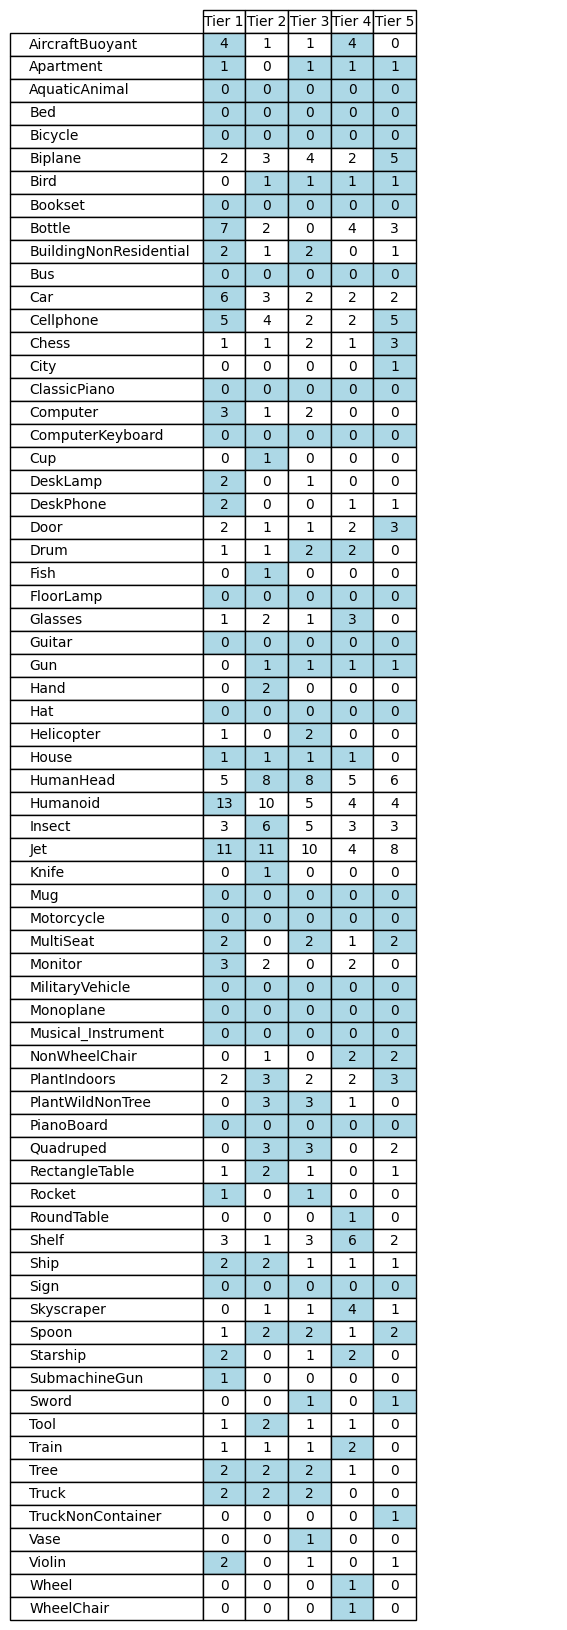

In [77]:
# Convert to DataFrame
df = pd.DataFrame(flattened_data, columns=['Classname', 'Tier Values'])

# Split the Tier Values into separate columns
df[['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5']] = pd.DataFrame(df['Tier Values'].tolist(), index=df.index)

# Drop the original Tier Values column
df = df.drop(columns=['Tier Values'])

# Set the Classname as the index
df = df.set_index('Classname')

# Plot the table as an image using matplotlib
fig, ax = plt.subplots()  # Adjust the height based on the number of rows

ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 rowLabels=df.index,
                 cellLoc='center',
                 loc='center')

# Highlight the highest number in each row with a light blue background
for i, row in enumerate(df.values):
    max_val = np.max(row)
    for j, val in enumerate(row):
        if val == max_val:
            table[(i+1, j)].set_facecolor('#ADD8E6')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(0.43, len(df) * 0.02)  # Adjust the scale based on the number of rows

plt.savefig("classnames_tiers_table.png", bbox_inches='tight')
plt.show()

[0.24087591 0.2189781  0.20194647 0.17518248 0.16301703]


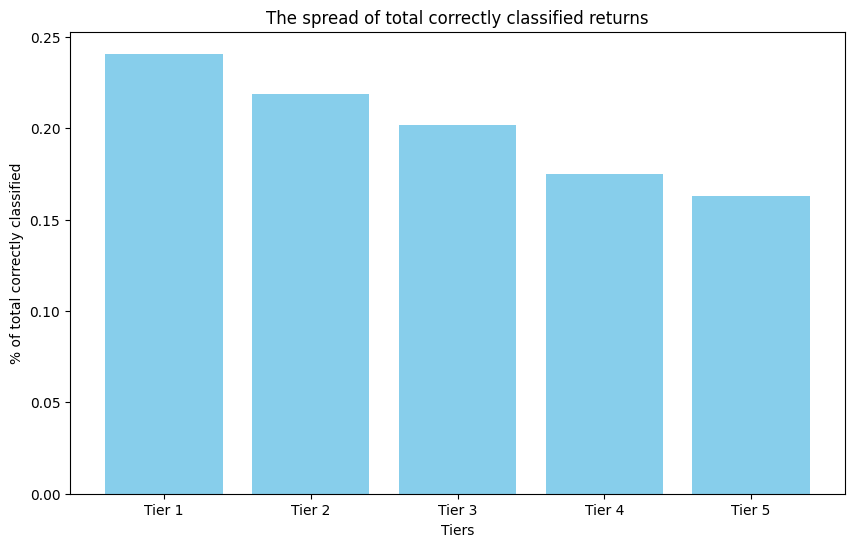

In [85]:
t1 = df['Tier 1'].sum()
t2 = df['Tier 2'].sum()
t3 = df['Tier 3'].sum()
t4 = df['Tier 4'].sum()
t5 = df['Tier 5'].sum()
countsTier = [t1, t2, t3, t4, t5]
total = sum(countsTier)
import matplotlib.pyplot as plt
import numpy as np

# Data provided by the user
data = countsTier/total
print(data)
# X-axis labels
x_labels = ['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5']

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_labels, data, color='skyblue')


# Add labels and title
plt.xlabel('Tiers')
plt.ylabel('% of total correctly classified')
plt.title('The spread of total correctly classified returns')

# Display the plot
plt.show()

In [64]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance

class FeatureComparator:
    def __init__(self, hist_features, single_val_features):
        self.hist_features = hist_features
        self.single_val_features = single_val_features
        self.all_distances = []

    def compare(self, df):
        for index, row in df.iterrows():
            print(f"Comparing: {row['name']}")

            distance_features = {}
            for hist_feature in self.hist_features:
                source = np.array(eval(row[hist_feature]))
                targets = df[hist_feature]

                distance_feature = []
                for target in targets:
                    target = np.array(eval(target))
                    d = wasserstein_distance(source, target)
                    distance_feature.append(np.sqrt(d))

                distance_features[hist_feature] = distance_feature

            for single_val_feature in self.single_val_features:
                source = row[single_val_feature]
                targets = df[single_val_feature]

                distance_feature = []
                for target in targets:
                    distance_feature.append(abs(source - target))

                distance_features[single_val_feature] = distance_feature

            standardized_distance_features = {"name": df["name"].to_list(),
                                              "class": df["class"].to_list()}
            for distance_feature_key, distance_feature_values in distance_features.items():
                if distance_feature_key in self.hist_features:
                    mean = np.mean(distance_feature_values)
                    std = np.std(distance_feature_values)

                    standardized_distance_feature = []
                    for distance_feature_value in distance_feature_values:
                        standardized_distance_feature.append((distance_feature_value - mean) / std)

                    standardized_distance_features[distance_feature_key] = standardized_distance_feature
                else:
                    standardized_distance_features[distance_feature_key] = distance_feature_values

            self.all_distances.append(self.combineFeatureDistances(standardized_distance_features))

        # Combine all distances into a single dataframe
        final_df = pd.concat(self.all_distances, ignore_index=True)
        final_df.to_csv("simpleSearching.csv", index=False)
        print("[Finished] All distances saved to simpleSearching.csv")

    def combineFeatureDistances(self, standardized_distance_features):
        df_distances = pd.DataFrame(standardized_distance_features)

        df_distances = pd.concat([df_distances[["name", "class"]], df_distances.iloc[:, 2:].abs()], axis=1)

        df_distances["closeness"] = df_distances.iloc[:, 2:].mean(axis=1)
        df_distances = df_distances.sort_values(["closeness"], ascending=True)

        return df_distances

# Load the dataframe
df = pd.read_csv("dataBaseNormalised.csv")

# Define the histogram and single value features
hist_features = ['A3', 'D1', 'D2', 'D3', 'D4']
single_val_features = ['surfaceAreaObj', 'compactnessObj', 'rectangularityObj', 'diameterObj', 'convexityObj', 'eccentricityObj']

# Create the FeatureComparator instance
comparator = FeatureComparator(hist_features, single_val_features)

# Perform the comparison
comparator.compare(df)


Comparing: m1337.obj
Comparing: m1338.obj
Comparing: m1339.obj
Comparing: m1340.obj
Comparing: m1341.obj


KeyboardInterrupt: 